In [ ]:
import copy

import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import grad
from torch.optim import Optimizer

import sys
import glob
import os
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
class SimpleModel(nn.Module):
    def __init__(self):
        super(SimpleModel, self).__init__()

        self.nonlin = torch.tanh

        self.lin1 = torch.nn.Linear(1, 1)
        #self.lin2 = torch.nn.Linear(1, 1)



    def forward(self, x):

        #x = x * 0

        #return self.lin1(x) + self.lin2(x - 0.5)
        return self.lin1(x)


In [ ]:
def calculateGradVector(model, sizeTotal):

    count1 = 0
    gradNow = np.zeros((sizeTotal,))
    for param in model.parameters():
        size1 = param.nelement()
        grad1 = param.grad
        #print (grad1)
        grad1 = grad1.data.numpy()
        grad1 = grad1.reshape((size1,))

        gradNow[count1:count1+size1] = np.copy(grad1)
        count1 += size1

    return gradNow


def findDataGrad(X, Y, model, optimizer, sizeTotal):

    dataGrad = np.zeros((X.shape[0],  sizeTotal))

    for a in range(X.shape[0]):
        pred1 = model(X[a:a+1])
        loss1 = (pred1[0] - Y[a]) ** 2
        loss1.backward()

        gradNow = calculateGradVector(model, sizeTotal)
        dataGrad[a] = np.copy(gradNow)

        optimizer.zero_grad()

    return dataGrad

def getOptSquare(optimizer, sizeTotal):

    count1 = 0
    stateVal = np.zeros(sizeTotal)
    for state1 in optimizer.state.values():
        param = state1['square_avg']
        size1 = param.nelement()

        param = param.data.numpy()

        stateVal[count1:count1+size1] = np.copy(param)
        count1 += size1

    return stateVal


In [51]:
def trainModel():

    N = 100
    X = np.arange(N).astype(float) / N
    Y = np.copy(X)
    Y[Y>0.9] = Y[Y>0.9] + ((X[Y>0.9] - 0.9) * 3)



    X = X.reshape((-1, 1))

    X = X - np.mean(X)
    #X = X - 1
    # X = X - 0.5
    #X = X - 0.945
    #X = X - 0.95

    X = torch.tensor(X).float()
    Y = torch.tensor(Y).float()

    weight1 = torch.zeros(Y.shape[0]).float()



    model = SimpleModel()

    sizeTotal = 0
    for param in model.parameters():
        size1 = param.nelement()
        sizeTotal += size1


    argKeep = np.arange(N)

    Nreq = 5#20
    dataVlues = np.zeros((Nreq, N)) - 1

    nPrint = 1000

    learningRate = 1e-2
    #learningRate = 1e-4
    # optimizer = torch.optim.Adam(model.parameters(), lr = learningRate)
    optimizer = torch.optim.RMSprop(model.parameters(), lr = learningRate, alpha=0.95)
    #optimizer = torch.optim.SGD(model.parameters(), lr = learningRate)
    #optimizer = RMSprop(model.parameters(), lr = learningRate)

    iterNum = 10000

    paramList = np.zeros((iterNum, 2))
    keepSize = np.zeros(iterNum)

    validGradSum = np.zeros(sizeTotal)
    validAbsSum = np.zeros(sizeTotal)


    for iter in range(0, iterNum):

        dataGrad = findDataGrad(X, Y, model, optimizer, sizeTotal)

        if iter > 50:

            stateVal = getOptSquare(optimizer, sizeTotal)
            stateVal = stateVal ** 0.5

            if iter % nPrint == 0:
                print ('stateVal', stateVal[1], stateVal[0])

            stateVal = stateVal.reshape((1, stateVal.shape[0]))
            dataGrad = dataGrad * (1 / stateVal)


        argsort1 = np.argsort(Y.data.numpy())
        topX = argsort1[  -argsort1.shape[0] // 10:  ]

        pred = model(X[topX])
        pred = pred[:, 0]

        validLoss = torch.mean( (pred - Y[topX]) ** 2  )
        validLoss.backward()


        beta1 = 0.02
        validGrad = calculateGradVector(model, sizeTotal)
        validGradSum = (validGradSum * (1 - beta1)) + (validGrad * beta1)
        validAbsSum = (validAbsSum * (1 - beta1)) + (np.abs(validGrad) * beta1)

        #print (validGrad[1] * -1, validGrad[0] * -1)
        #quit()
        validDir = validGradSum / validAbsSum
        validDir = validDir.reshape((1, validDir.shape[0]))
        # dataGrad2 = dataGrad/np.mean(dataGrad, axis=0)
        # validDir2 = validDir/np.mean(validDir, axis=0)
        # print(validDir, dataGrad)
        dataValue = np.sum(validDir * dataGrad, axis=1)

        dataVlues[iter % Nreq] = np.copy(dataValue)

        #pred = model(X[argKeep])
        #pred = pred[:, 0]
        #loss = torch.mean( (pred - Y[argKeep]) ** 2  )

        pred = model(X)
        pred = pred[:, 0]
        loss = torch.mean( weight1 * (pred - Y) ** 2  )


        optimizer.zero_grad()
        loss.backward()
        optimizer.step()


        #print ("")
        a0 = 0
        for param in model.parameters():
            paramList[iter, a0] = param[0]
            a0 += 1

        if iter%nPrint == 0:

            plt.plot(paramList[iter-nPrint:iter, 1])
            plt.plot(paramList[iter-nPrint:iter, 0])
            plt.plot(keepSize[iter-nPrint:iter] / nPrint)
            plt.show()


        if iter % nPrint == 0:

            #Slope, Intercept, loss grad
            print ('')
            print ('Param', paramList[iter, 1], paramList[iter, 0])
            print ('validGrad', validDir[0][1] * -1, validDir[0][0] * -1)
            #print (loss)
            print ('Mean', np.mean(pred[topX].data.numpy()), np.mean(Y[topX].data.numpy()) )

            dataValue_plot = dataValue / np.mean(np.abs(dataValue))
            dataGrad_plot = -1 * dataGrad / np.mean(np.abs(dataGrad))

            #plt.scatter(X[:, 0].data.numpy(), Y.data.numpy())
            #print (pred.shape, argKeep.shape)
            #plt.scatter(X[argKeep, 0].data.numpy(), pred.data.numpy())
            #plt.scatter(X[:, 0].data.numpy(), dataValue_plot)
            #plt.scatter(X[topX, 0].data.numpy(), Y[topX].data.numpy())
            #plt.scatter(X[:, 0].data.numpy(), dataGrad[:, 0]*-1)
            #plt.scatter(X[:, 0].data.numpy(), dataGrad[:, 1]*-1)
            #plt.show()

            figure, axis = plt.subplots(2)
            axis[0].plot(X[:, 0].data.numpy(), Y.data.numpy())
            axis[0].scatter(X[argKeep, 0].data.numpy(), pred.data.numpy())
            axis[0].plot(X[topX, 0].data.numpy(), Y[topX].data.numpy())

            axis[1].scatter(X[:, 0].data.numpy(), dataGrad_plot[:, 1])
            axis[1].scatter(X[:, 0].data.numpy(), dataGrad_plot[:, 0])
            axis[1].plot(X[:, 0].data.numpy(), dataValue_plot)

            axis[1].plot(X[:, 0].data.numpy(), weight1.data.numpy())
            plt.show()


        # weight1[dataValue > 0] = weight1[dataValue > 0] + 0.05
        # weight1[dataValue < 0] = weight1[dataValue < 0] - 0.05
        weight1[dataValue > 0] = weight1[dataValue > 0] + 5000/(iter+1)**2
        weight1[dataValue < 0] = weight1[dataValue < 0] - 5000/(iter+1)**2
        weight1[weight1 < 0] = 0
        weight1[weight1 > 1] = 1

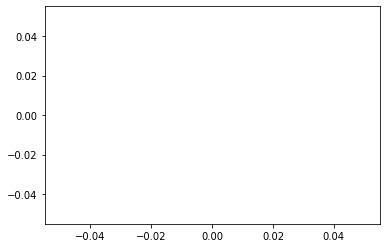


Param 0.11143743991851807 0.9305686950683594
validGrad 1.0 1.0
Mean 0.5301933 1.08


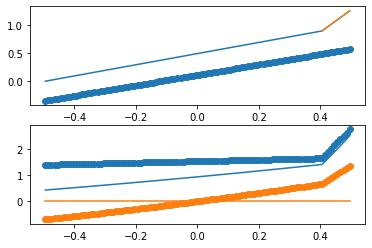

stateVal 0.001618508523624365 0.0007209272830549081


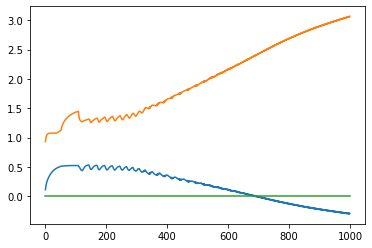


Param -0.30268245935440063 3.0587804317474365
validGrad -0.14692161570252238 0.11273326035868196
Mean 1.0880915 1.08


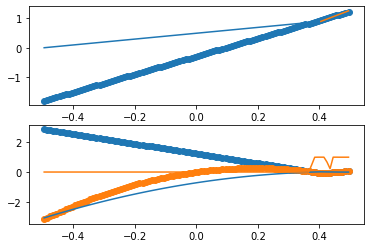

stateVal 0.0014144297093753907 0.0006338604881357206


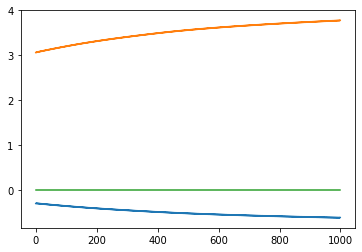


Param -0.6239223480224609 3.7708795070648193
validGrad -0.04869832619023709 0.012015554673387297
Mean 1.0875124 1.08


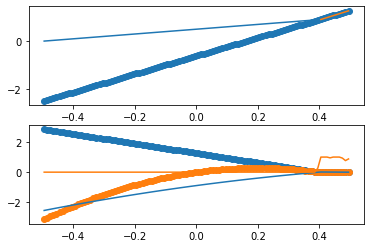

stateVal 0.0014538209753799033 0.0006550002118521085


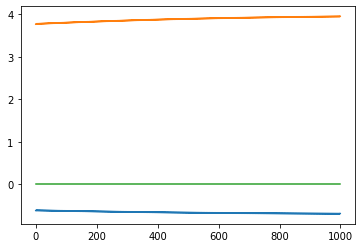


Param -0.7029834389686584 3.946323871612549
validGrad -0.026284886460329473 -0.012978169952036848
Mean 1.0873613 1.08


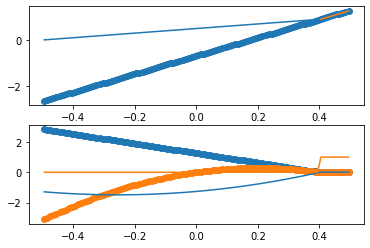

stateVal 0.0014537164982293422 0.0006548260569696494


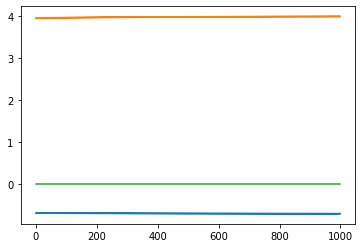


Param -0.7188674807548523 3.9815616607666016
validGrad -0.021871397808585494 -0.018274852139699385
Mean 1.0873344 1.08


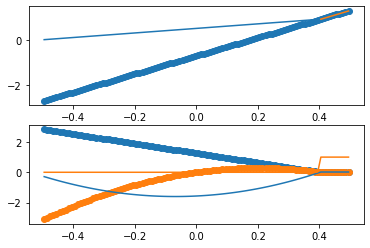

stateVal 0.0014483299751912404 0.0006529731246526713


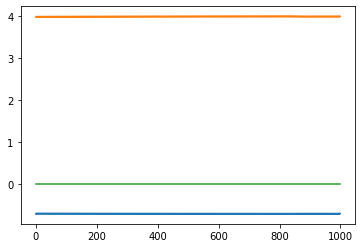


Param -0.7208976745605469 3.986074209213257
validGrad -0.021075693383277333 -0.018801161203964536
Mean 1.0873398 1.08


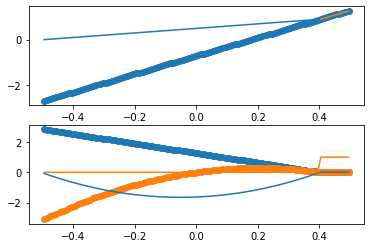

stateVal 0.001449593744753275 0.0006534093550099064


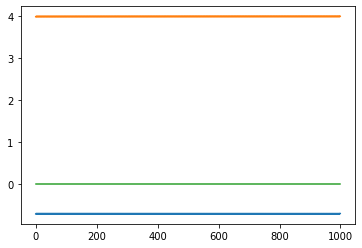


Param -0.7215622663497925 3.987531900405884
validGrad -0.020927812106646102 -0.019020734711435276
Mean 1.0873297 1.08


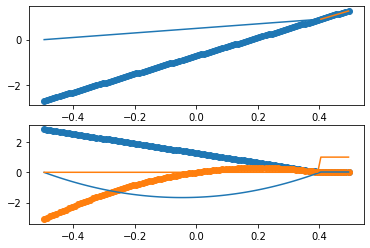

stateVal 0.0014498344162826866 0.0006535032594836711


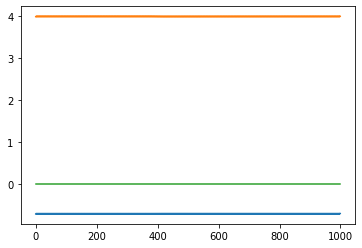


Param -0.7214629054069519 3.987318754196167
validGrad -0.02092870033844514 -0.01896462460510693
Mean 1.0873302 1.08


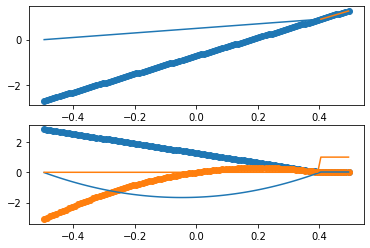

stateVal 0.0014501213035178144 0.0006535953458335059


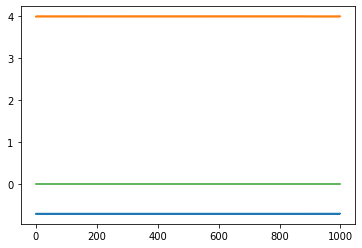


Param -0.7213453650474548 3.9870519638061523
validGrad -0.020922145502993587 -0.018912386183132932
Mean 1.0873303 1.08


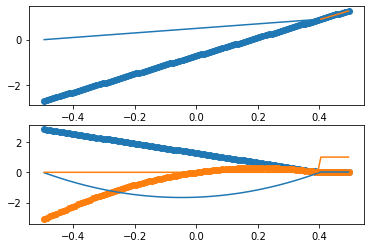

stateVal 0.0014505707688945053 0.0006537435265199173


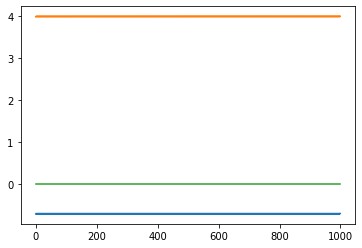


Param -0.7216110825538635 3.987640142440796
validGrad -0.020876739125958315 -0.01900194502506237
Mean 1.0873293 1.08


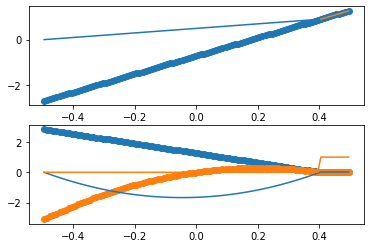

In [52]:
trainModel()